# Analysis of experience based on words in reviews

As we observed, experience seems to play a significant role in how, and particularly how well, individuals rate their beers. However, it is fair to question whether the total number of previous ratings is truly a perfect measure of a user's experience. While it certainly provides a useful indication and is a legitimate estimator, we wondered if there might be a more sophisticated way to identify experienced users. Epecially we wondered if there is maybe a way we could incorporate the text attribute of the ratings to say which users are qualified to be called "experienced".

As humans, we can often tell whether someone knows what they are talking or writing about, especially when we ourselves have expertise in the subject. This suggests that it might be possible to infer a type of "experience level" from the text of reviews.

However, performing an extensive sentiment analysis was beyond our resources, and a similar analysis had already been conducted by the authors of the paper we were provided with ("Learning Attitudes and Attributes from Multi-Aspect Reviews" by Julian McAuley, Jure Leskovec, and Dan Jurafsky, [IEEE Paper](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6413815)). Our supervisor advised us not to replicate this exact analysis. 

Therefore, we implemented a simpler method to quantify experience in beer reviews.

## A word-based experience metric

There are numerous resources on how to describe beer, and for "beer sommeliers," there are even specific guidelines on how to assess and articulate beer characteristics. We searched the internet for a list of terms rarely used in everyday language but frequently employed by beer experts to describe beer. We aimed for a balanced selection of terms meaning that we wanted to have roughly the same number of:

- **Positive Terms** (e.g., "Lacing," which refers to the foam that clings to the inside of a glass)
- **Neutral Terms** (e.g., "Brettanomyces," a wild, non-domesticated yeast)
- **Negative Terms** (e.g., "Diacetyl," an off-flavor that can develop during fermentation)

This balanced approach was intended to avoid introducing bias toward any particular sentiment within the "experienced" group. We compiled our list with significant help from the bachelor’s thesis "Terminology in Beer Reviews" by Malin Norman from the University of Gävle ([Full Text PDF](https://www.diva-portal.org/smash/get/diva2:1294624/FULLTEXT01.pdf)).

## Defining an experienced User

Once the vocabulary list was complete, we defined what constitutes an "experienced user" based on two specific criteria:

1. **Usage of at least 5 unique terms**: The user must have used at least five distinct words from our list across all their reviews. This criterion was intended to prevent users who may have simply picked up one or two terms from other reviews from being classified as experienced.

2. **Frequency of term usage**: The user must have used at least one of the terms in a minimum of 10 reviews. This requirement should ensure that only those who consistently and knowledgeably discuss beer were included in the "experienced" group, excluding users who only occasionally or recently began using these terms.

With this definition in place, we were able to proceed with further analyses based on this experience-based classification.

In [18]:
from src.models.experience_words import  *
from src.models.foreign_beer import *

In [19]:
df_rb_ratings, df_ba_ratings = load_data()

Overall Progress: 100%|██████████| 100/100


Number of experienced users:  3959
Number of ratings by experienced users:  2555996
Average rating by experienced users:  3.8239121187983103

Number of inexperienced users:  66162
Number of ratings by experienced users:  5837036
Average rating by experienced users:  3.9076239413291276


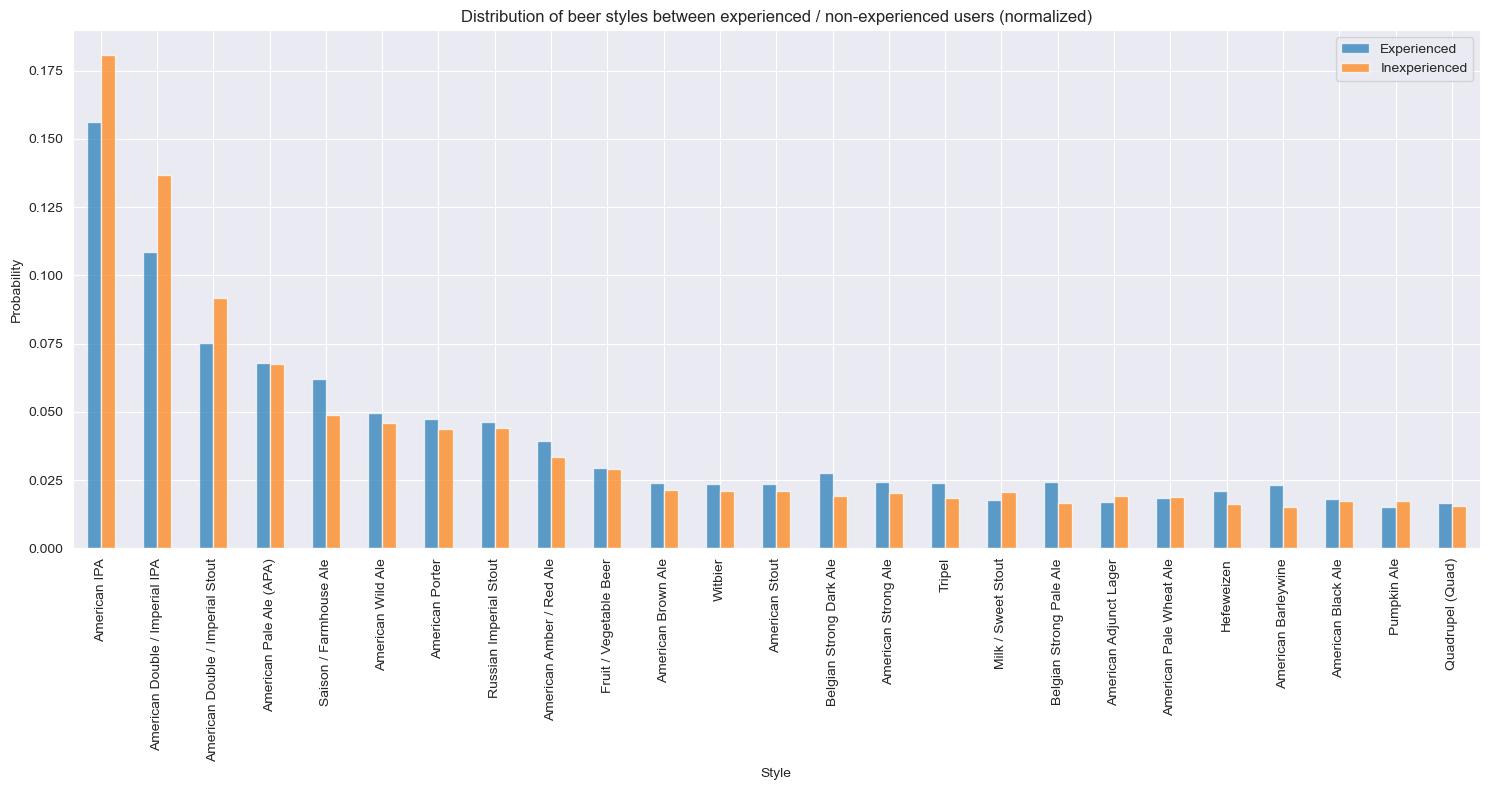

In [31]:
# creating the experienced / inexperienced groups
exp_user_ids_ba = get_experienced_users2(df_ba_ratings, exp_words1)
df_ba_ratings_of_exp, df_ba_ratings_of_inexp = split_by_experience(df_ba_ratings, exp_user_ids_ba)

# printing some interesting statistics
print("Number of experienced users: ", len(exp_user_ids_ba))
print("Number of ratings by experienced users: ", len(df_ba_ratings_of_exp))
print("Average rating by experienced users: ", df_ba_ratings_of_exp["rating"].mean())
print("\nNumber of inexperienced users: ", len(df_rb_ratings["user_id"].unique()) - len(exp_user_ids_ba))
print("Number of ratings by inexperienced users: ", len(df_ba_ratings_of_inexp))
print("Average rating by inexperienced users: ", df_ba_ratings_of_inexp["rating"].mean())

# we calculate an empirical distribution of the number of ratings over the beer styles for both groups and plot it
plot_df, most_rated = calculate_style_distribution(df_ba_ratings_of_exp, df_ba_ratings_of_inexp)
plot_style_distribution(plot_df)

This is already quite interesting. While we can see that the order of which beer styles are consumed more or less frequently is relatively similar between experienced and inexperienced beer drinkers, we also observe that for some beer styles, the frequency at which they are consumed differs significantly between the two groups. This is particularly true for the beer styles that are most popular among both groups.

To examine this further, let’s look at a **difference plot**. In this plot, we will display only one bar per beer style. The length of each bar indicates the difference in consumption frequency between experienced and inexperienced drinkers. The bar points downward if experienced users consume the style relatively less often, and upward if they consume it relatively more.

It’s important to note that this analysis does not reflect absolute frequencies across the entire dataset (as there are significantly more inexperienced users than experienced ones, absolute numbers would not be very informative). Instead, we are subtracting the **relative frequencies** within each group to get a meaningful comparison.


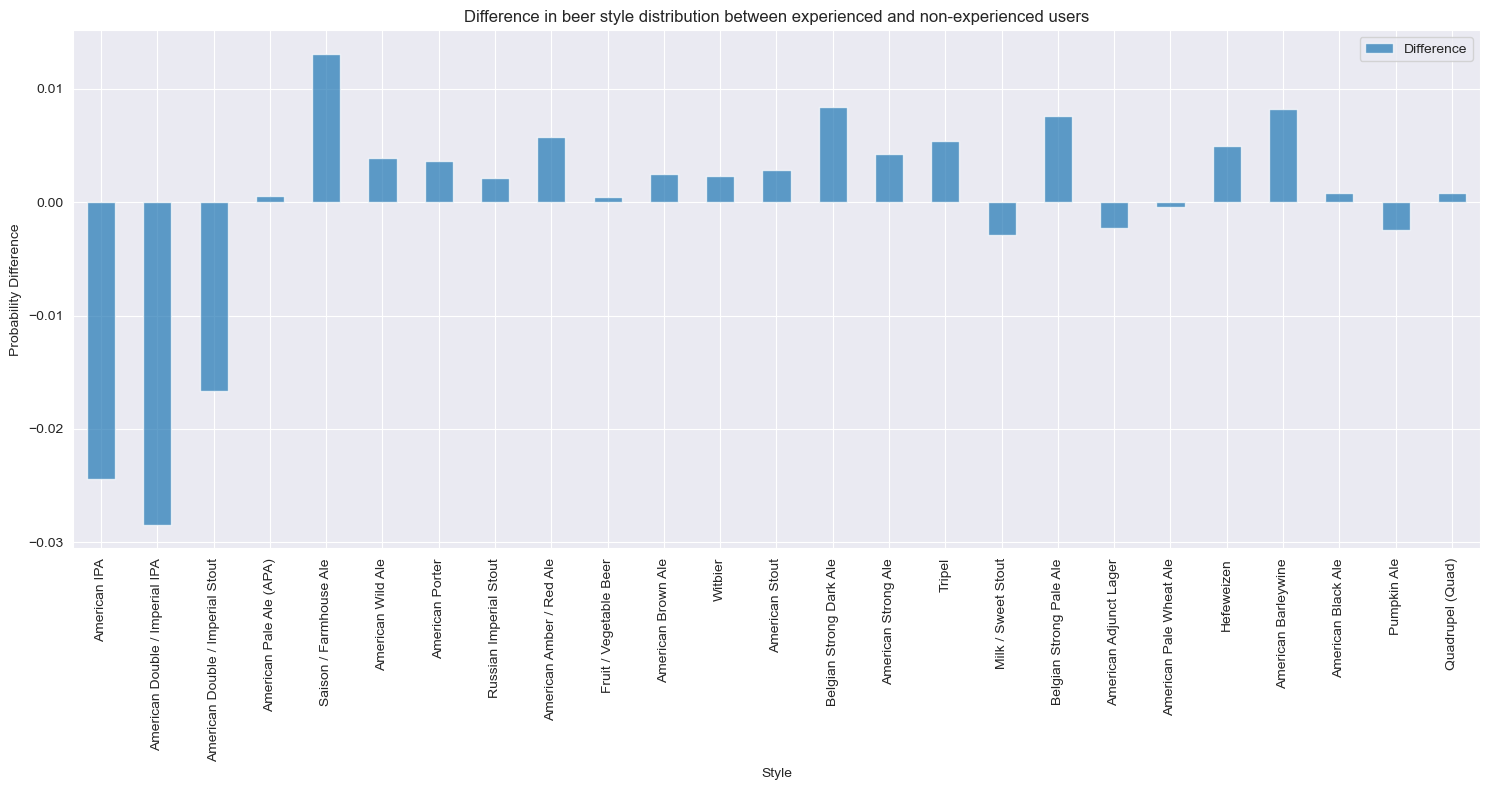

In [21]:
plot_distribution_difference(plot_df)

Now this is truly interesting. We observe that experienced users consume the most popular beer styles—namely, "American IPA," "American Double / Imperial IPA," and "American Double / Imperial Stout"—relatively much less than inexperienced users. However, for the "rarer" beer styles, the opposite trend emerges. 
With just a few exceptions, such as "Milk / Sweet Stout," "American Adjunct Lager," and "Pumpkin Ale", experienced users tend to consume lesser-known beer styles relatively more often than inexperienced users.

Now, let's turn our attention to ratings. In addition to the previous plot, we will now include a second plot (displayed below the first one) showing the **average rating per beer style** for each of the two groups (experienced and inexperienced users).

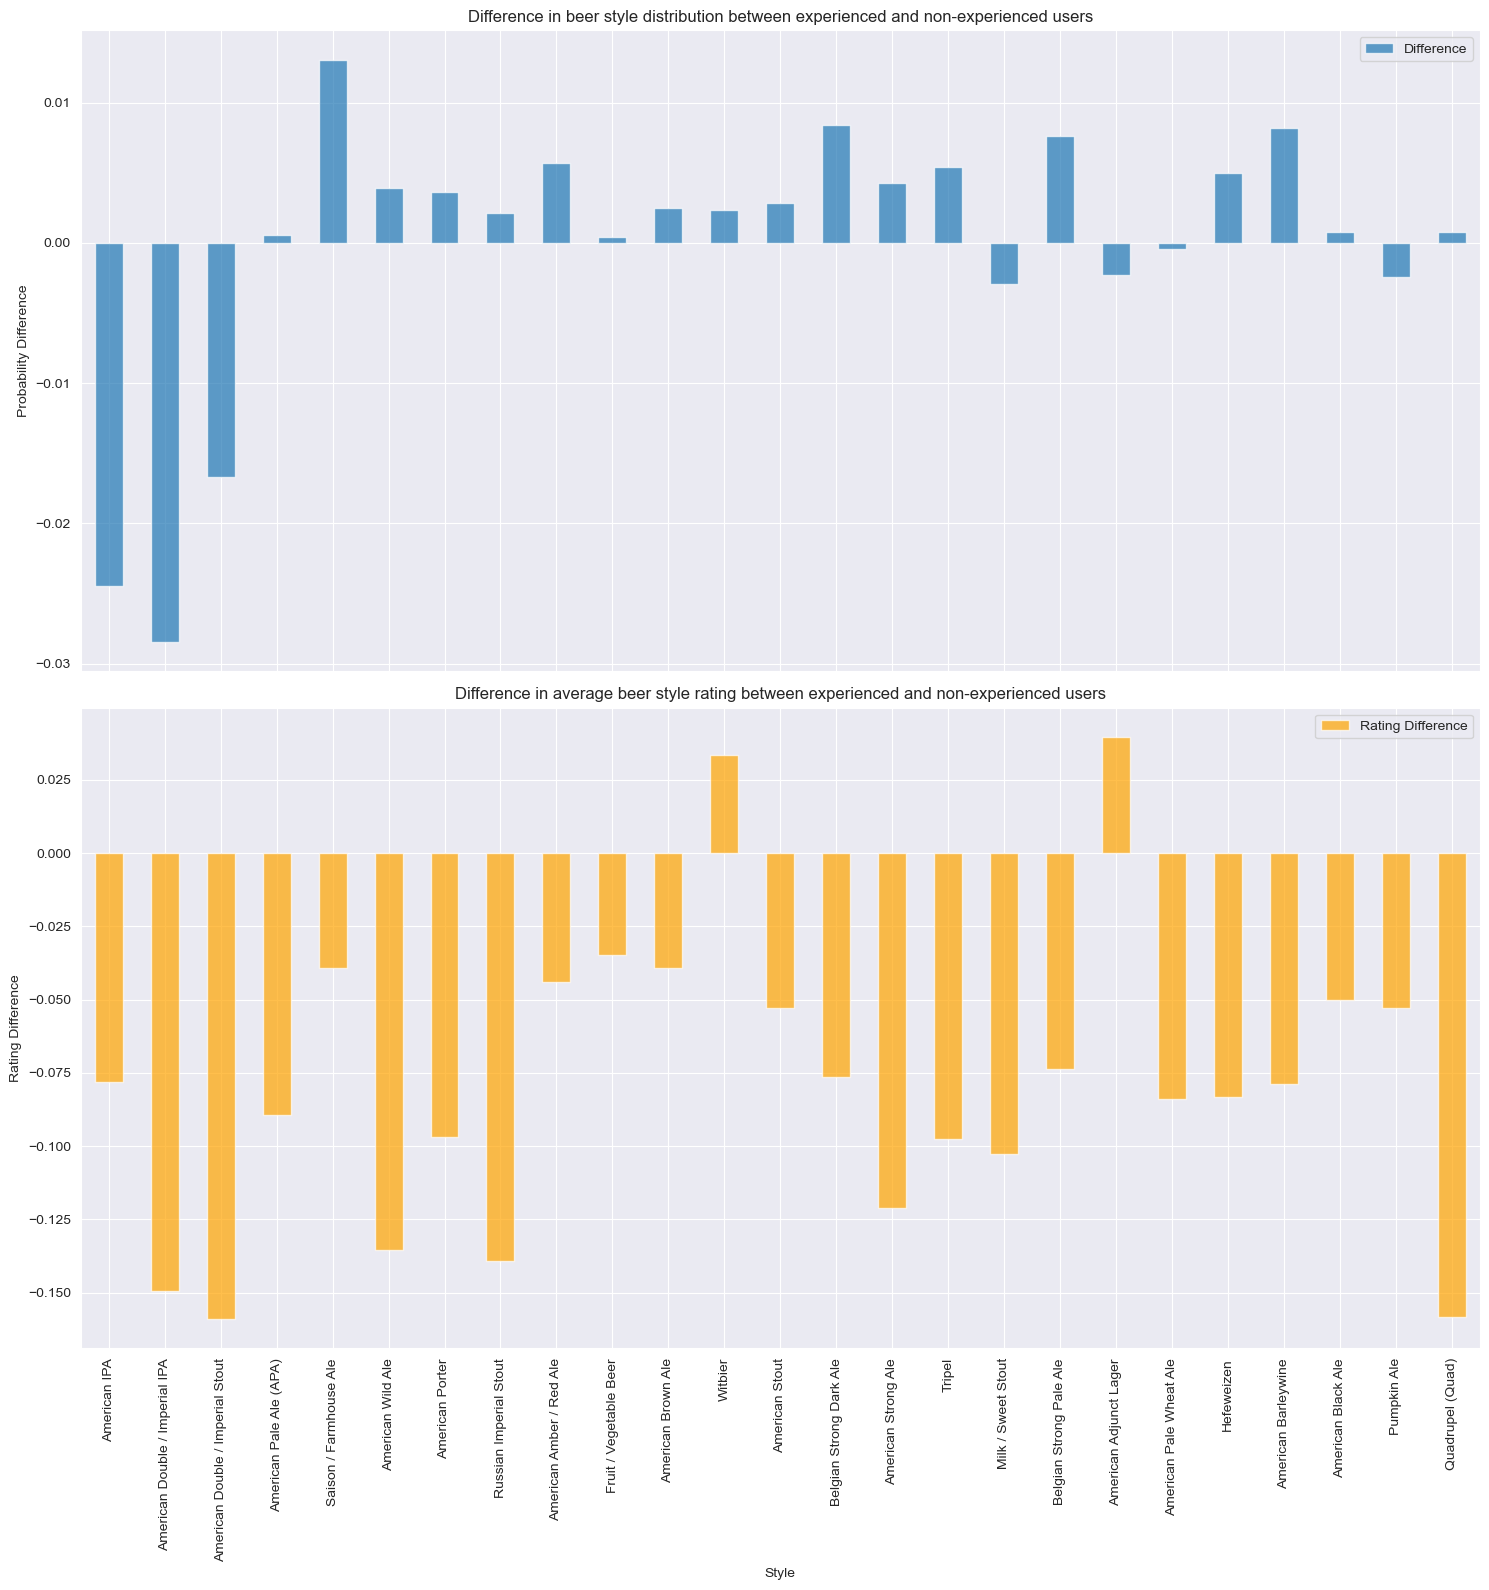

In [22]:
rating_diff_df = calculate_rating_difference(df_ba_ratings_of_exp, df_ba_ratings_of_inexp, most_rated)
plot_combined_distribution_and_rating_difference(plot_df, rating_diff_df)

This plot provides perhaps the most interesting insight we gain from our analysis of classifying experienced users based on their vocabulary. In the upper chart, we see the same (also interesting) information as before. However, in the lower chart, we observe the **average ratings** given per beer style for each group, as previously outlined.

We find that experienced users rate almost all beer styles **lower on average** than inexperienced drinkers, with the exceptions of "Witbier" and "American Adjunct Lager." This suggests that with greater experience, drinkers tend to have higher standards for their beers. Thus, when reading a review from an inexperienced versus an experienced beer drinker for the same beer, one should consider this potential bias in shaping expectations or assessments.
We already observed this difference in average ratings at the beginning when we calculated the overall average rating across all beer styles. Now, however, we can see the breakdown by each individual beer style. This additional information can help us better account for rating bias when assessing a particular review.


# Patriotism in beer reviews

In [23]:
df_ba_users, df_rb_users = load_user_data(ba_path="src/data/BeerAdvocate/users.csv", rb_path="src/data/RateBeer/users.csv")
df_rb_sum_rat = calculate_ratings_by_location(df_rb_users)
df_rb_sum_rat_foreign = accumulate_us(df_rb_sum_rat)
df_rb_sum_rat_cutoff = cutoff_and_sort(df_rb_sum_rat_foreign)

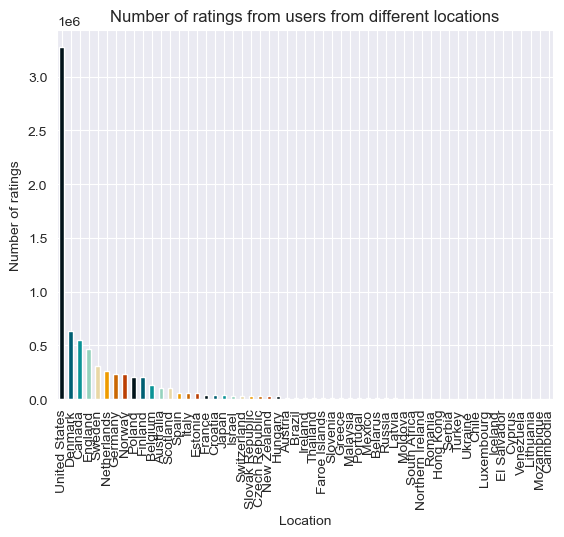

In [24]:
plot_location_ratings(df_rb_sum_rat_cutoff)

In [25]:
df_rb_ratings_wo_text = pd.read_csv("src/data/RateBeer/ratings/ratings.csv", usecols=lambda col: col != "text")

df_rb_users_us = accumulate_us2(df_rb_users, "location")
df_rb_users_ratings = merge_users_and_ratings(df_rb_ratings_wo_text, df_rb_users_us)
df_rb_users_ratings_top50, top50 = filter_top_countries(df_rb_users_ratings, top_n=50)

df_plot = avg_rating_by_location(df_rb_users_ratings_top50)

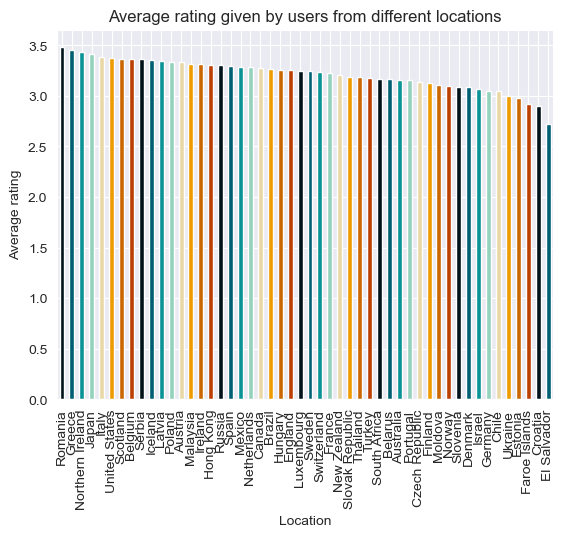

In [26]:
plot_mean_rating_by_location(df_plot)

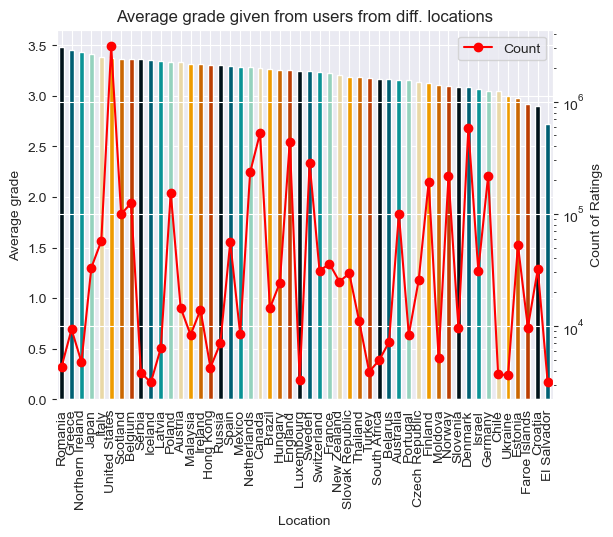

In [27]:
plot_mean_rating_and_rating_count(df_plot, top50)

In [28]:
df_brew = load_brewery(brewery_path="src/data/RateBeer/breweries.csv")
df_brew_us = accumulate_us2(df_brew, "brewery_location")
df_rb_users_ratings_brew = merge_ratings_with_breweries(df_rb_users_ratings_top50, df_brew_us)
num_foreign, num_own, foreign_percentage, own_percentage = foreign_beer_stats(df_rb_users_ratings_brew)
print(f"Number of ratings about foreign beers: {num_foreign}")
print(f"Number of ratings about beers from user's country: {num_own}")
print(f"That means {foreign_percentage:.2f}% are foreign beers and {own_percentage:.2f}% are beers from the user's country.")

Number of ratings about foreign beers: 3145912
Number of ratings about beers from user's country: 3739510
That means 45.69% are foreign beers and 54.31% are beers from the user's country.


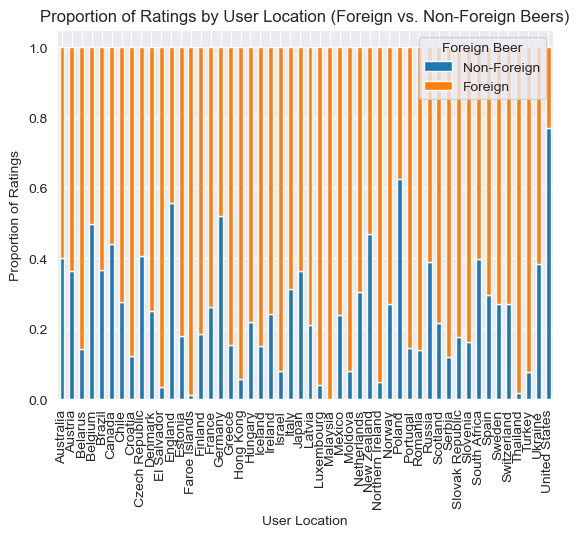

In [29]:
df_grouped_counts = grouped_counts(df_rb_users_ratings_brew)
plot_foreign_vs_own_beer_counts(df_grouped_counts)

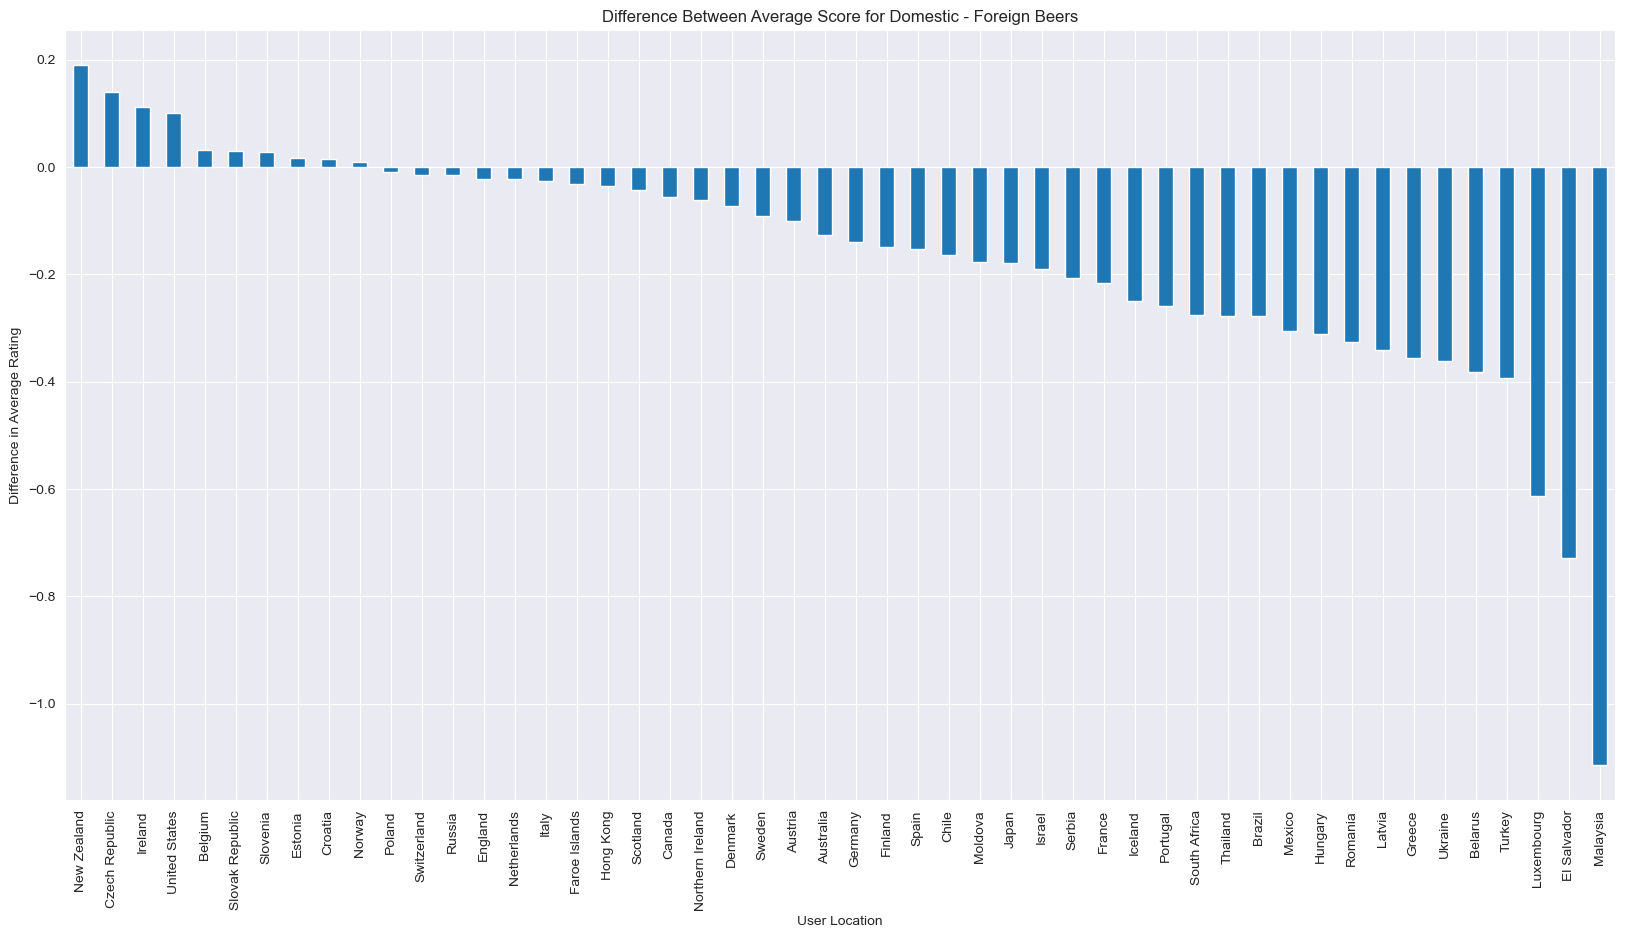

In [30]:
df_rb_users_ratings_brew = change_flag(df_rb_users_ratings_brew)
df_average_scores = avg_scores_domestic_foreign(df_rb_users_ratings_brew)
df_pivot = pivot_average_scores(df_average_scores)
df_pivot_diff = calculate_score_difference(df_pivot)
plot_score_difference(df_pivot_diff)